In [40]:
import os
# for the model
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# for data manipulation and graphing
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import display, HTML

tf.random.set_seed(42) # set seed for reproducibility
tf.debugging.set_log_device_placement(False)

## Data preprocessing

In [41]:
# load the dataset
# connectium
# original_dataset = pd.read_csv("C:/Users/franc/pasantia_IA/datasets/data_connectium.csv")
# sip
original_dataset = pd.read_csv("C:/Users/franc/pasantia_IA/datasets/data_sip.csv")

# show the original data
original_dataset.head()

,Task_ID,Priority,Project_ID,Project_code,Category,Total_developers,TaskPerformance,DeveloperPerformance,Hours_estimate,Hours_logged,Difference
0,13728,1,10,PC10,Enhancement,1,6.47,6.47,28.0,21.53,6.47
1,3530,1,9,PC9,Bug,1,6.46,6.46,7.0,0.54,6.46
2,6163,1,9,PC9,Release,1,-6.45,-3.95,2.0,8.45,6.45
3,6163,1,9,PC9,Release,1,-6.45,NaN,2.0,8.45,6.45
4,11241,1,9,PC9,Enhancement,1,-6.38,-5.68,70.0,76.38,6.38


In [42]:
# show the metadata
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4055 entries, 0 to 4054
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Task_ID               4055 non-null   int64  
 1   Priority              4055 non-null   int64  
 2   Project_ID            4055 non-null   int64  
 3   Project_code          4055 non-null   object 
 4   Category              4055 non-null   object 
 5   Total_developers      4055 non-null   int64  
 6   TaskPerformance       4055 non-null   float64
 7   DeveloperPerformance  3662 non-null   float64
 8   Hours_estimate        4055 non-null   float64
 9   Hours_logged          4055 non-null   float64
 10  Difference            4055 non-null   float64
dtypes: float64(5), int64(4), object(2)
memory usage: 348.6+ KB


In [43]:
# drop all the unnecessary columns
clean_dataset = original_dataset[[
    
    'Priority',
    'Category',
    'Total_developers',
    'Hours_estimate',
    'Hours_logged',
]]

# desnormalizing data
clean_dataset = pd.get_dummies(clean_dataset, columns=['Category'])
clean_dataset = clean_dataset.astype(int)

In [44]:
clean_dataset.head()

,Priority,Total_developers,Hours_estimate,Hours_logged,Category_Bug,Category_Enhancement,Category_Release,Category_Testing
0,1,1,28,21,0,1,0,0
1,1,1,7,0,1,0,0,0
2,1,1,2,8,0,0,1,0
3,1,1,2,8,0,0,1,0
4,1,1,70,76,0,1,0,0


In [45]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4055 entries, 0 to 4054
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Priority              4055 non-null   int32
 1   Total_developers      4055 non-null   int32
 2   Hours_estimate        4055 non-null   int32
 3   Hours_logged          4055 non-null   int32
 4   Category_Bug          4055 non-null   int32
 5   Category_Enhancement  4055 non-null   int32
 6   Category_Release      4055 non-null   int32
 7   Category_Testing      4055 non-null   int32
dtypes: int32(8)
memory usage: 126.8 KB


### Data sampling

Split the data into train, test and validate samples to fit and evaluate the model

The percentage of each one will be

- 60% training
- 20% testing
- 20% validating

In [47]:
train_dataset, temp_test_dataset = train_test_split(clean_dataset, test_size=0.20)

validation_dataset, test_dataset = train_test_split(temp_test_dataset, test_size=0.50)

print("Samples shape")
print(f"    Train: {train_dataset.shape}")
print(f"    Test: {test_dataset.shape}")
print(f"    Validation: {validation_dataset.shape}")

Samples shape
    Train: (3244, 8)
    Test: (406, 8)
    Validation: (405, 8)


### Data analysis

Calculate the correlation and other statistics on the train dataset

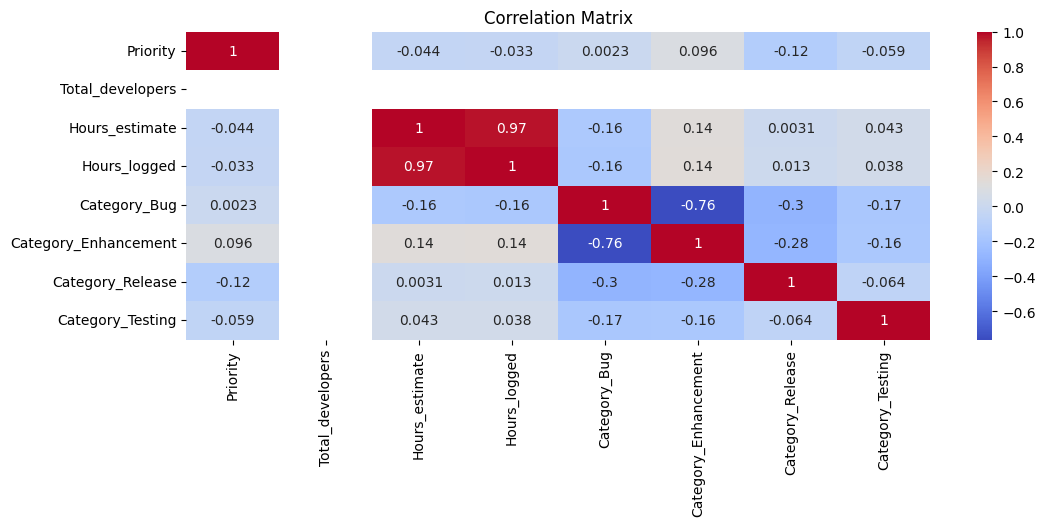

In [48]:
# correlation between the features and the target

correlation_matrix = clean_dataset.corr()
correlation_matrix['Hours_logged'].sort_values(ascending=False)

# plot the correlation matrix
plt.figure(figsize=(12, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [49]:
# another interesting statistics like the count, mean, std, min, quartiles and max, all per feature
train_stats = train_dataset.describe()
train_stats.pop("Hours_logged")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Priority,3244.0,2.298705,1.793327,1.0,1.0,1.0,3.0,10.0
Total_developers,3244.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Hours_estimate,3244.0,4.427867,9.288140,0.0,1.0,2.0,5.0,260.0
Category_Bug,3244.0,0.442355,0.496743,0.0,0.0,0.0,1.0,1.0
Category_Enhancement,3244.0,0.421702,0.493907,0.0,0.0,0.0,1.0,1.0
Category_Release,3244.0,0.100493,0.300703,0.0,0.0,0.0,0.0,1.0
Category_Testing,3244.0,0.035450,0.184943,0.0,0.0,0.0,0.0,1.0


### Feature prediction

The label "Hours Logged" is the actual goal for our model, we will remove it from every sample and keep it apart

In [50]:
train_label = train_dataset.pop('Hours_logged')
test_label = test_dataset.pop('Hours_logged')
validation_label = validation_dataset.pop('Hours_logged')

### Data normalization/Scaling

Subtract the mean of the training data and divide by the standard deviation of the training data.

In [51]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_validation_data = norm(validation_dataset)

# is some of the data is NaN, fill it with 1
if normed_train_data['Total_developers'].isna().any():
    normed_train_data['Total_developers'] = normed_train_data['Total_developers'].fillna(1)
    normed_test_data['Total_developers'] = normed_test_data['Total_developers'].fillna(1)
    normed_validation_data['Total_developers'] = normed_validation_data['Total_developers'].fillna(1)

In [52]:
# show a part of the normalized data
normed_train_data.head()

,Priority,Total_developers,Hours_estimate,Category_Bug,Category_Enhancement,Category_Release,Category_Testing
1623,1.506304,1.0,-0.369058,-0.890512,1.170864,-0.334194,-0.191681
3207,0.391058,1.0,-0.476723,1.122603,-0.853807,-0.334194,-0.191681
1757,-0.724188,1.0,-0.369058,-0.890512,1.170864,-0.334194,-0.191681
417,-0.724188,1.0,-0.261394,1.122603,-0.853807,-0.334194,-0.191681
2535,1.506304,1.0,0.276927,-0.890512,-0.853807,2.991348,-0.191681


## Building the Models

### Firts Model
Two hidden layers with 50 neurons each

In [53]:
def build_first_model_two_hidden_layers():
    model = Sequential(name = "FirstModelTwoHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(50, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(50, Activation('relu'), name='hidden_layer_2'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.001
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

    return model

### Second Model

Three hidden layers with 32, 64 and 128 neurons, respectively

In [56]:
def build_second_model_three_hidden_layers():
    model = Sequential(name = "SecondModelThreeHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(128, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_3'))
    model.add(Dense(32, Activation('relu'), name='hidden_layer_2'))
    
    
    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.001
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

    return model

### Third Model

Five hidden layers, all with 64 neurons

In [57]:
def build_third_model_five_hidden_layers():
    model = Sequential(name = "ThirdModelFiveHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(64, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_2'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_3'))
    
    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['accuracy', 'mae', 'mse']
    )

    return model

### Fourth Model

LSTM Neural Network

In [58]:
def build_fourth_model_LSTM_hidden_layers():
    model = Sequential(name = "FourthModelLSTMHiddenLayers")

    model.add(Reshape(
        (normed_train_data.shape[1], 1),
        input_shape=(normed_train_data.shape[1],)
    ))

    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(32, Activation('relu')))
  
    
    model.add(Dense(1))

    learnig_rate = 0.0001
    optimizer = optimizers.Adam(learning_rate=learnig_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

    return model    

### Fith Model

Support Vector Machine

In [59]:
def build_model_svc():
    parameters = {'kernel':('linear', 'rbf')}
    svr = SVR()
    return GridSearchCV(svr, parameters)

### Choose the model

In [60]:
def choose_model(model_type, model_number):
    if (model_type == 'Neuronal Network'):
        if (model_number == 1):
            return build_first_model_two_hidden_layers()
        elif (model_number == 2):
            return build_second_model_three_hidden_layers()
        elif (model_number == 3):
            return build_third_model_five_hidden_layers()
        elif (model_number == 4):
            return build_fourth_model_LSTM_hidden_layers()
    else:
        return build_model_svc()

Save checkpoints during training

In [61]:
# checkpoint_path = r".\checkpoint_logs\connectium\data.ckpt"
checkpoint_path = r".\checkpoint_logs\sip\data.ckpt"

# Create a callback that saves the model's weights
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', # or val_accuracy if you have it.
                                                 save_best_only=True, # Default false. If you don't change the file name then the output will be overritten at each step and only the last model will be saved.
                                                 save_weights_only=True, # True => model.save_weights (weights and no structure, you need JSON file for structure), False => model.save (saves weights & structure)
                                                 verbose=0,
)

tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True)

## Model training

In [62]:
def training_neural_network_model(model, n_folds):
    kFold = KFold(n_splits=n_folds)

    histories = []

    print("Summary of the model")
    model.summary()

    i = 0

    for train_index, val_index in kFold.split(normed_train_data):
        train_data_i, val_data_i = normed_train_data.iloc[train_index], normed_train_data.iloc[val_index]
        train_label_i, val_label_i = train_label.iloc[train_index], train_label.iloc[val_index]


        # for first model - second place
        # epochs = 64
        # batch_size = 10 

        # for second model - worst for now
        # epochs = 400
        # batch_size = 60

        # for third model -
        # epochs = 64
        # batch_size = 10

        # for fourth model - is winning
        epochs = 300
        batch_size = 100

        print("\nTraining the model - K Validation: ", i, "\n")

        history = model.fit(
            train_data_i,
            train_label_i,
            batch_size=batch_size,  
            epochs=epochs, 
            verbose=0,
            shuffle=True,
            steps_per_epoch = int(train_data_i.shape[0] / batch_size),
            validation_data=(val_data_i, val_label_i),
            callbacks=[
                tfdocs.modeling.EpochDots(),
                ckpt_callback,
            ]
        )

        histories.append(history)
        i = i + 1
    
    return histories

In [63]:
def training_support_vector_machine_model(model, folds):
    scores = cross_val_score(model, normed_train_data, train_label, cv=folds)
    
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
    model.fit(normed_train_data, train_label)
    model.fit(normed_train_data, train_label)
    
    history = pd.DataFrame({
        'Accuracy': [model.score(normed_test_data, test_label)],
        'Best params hash': [model.best_params_],
        'Best score': [model.best_score_],
        'Best estimator': [model.best_estimator_],
    })

    print(history)
    return history

In [64]:
%%time

model = choose_model('Neuronal Network', 4)
# model = choose_model('Support Vector Machine', 0)

histories = training_neural_network_model(model, 4)
# history = training_support_vector_machine_model(model, 4)

Summary of the model
Model: "FourthModelLSTMHiddenLayers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 7, 1)              0         
                                                                 
 lstm_2 (LSTM)               (None, 7, 128)            66560     
                                                                 
 dropout_2 (Dropout)         (None, 7, 128)            0         
                                                                 
 flatten_2 (Flatten)         (None, 896)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                28704     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9529

Traceback (most recent call last):
  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\magics\execution.py", line 1340, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 4, in <module>
  File "C:\Users\franc\AppData\Local\Temp\ipykernel_10084\3629522322.py", line 22, in training_neural_network_model
    history = model.fit(
  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1874, in fit
    callbacks.on_epoch_end(epoch, epoch_logs)
  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFounda

## Predicting the data

### Predicted and real values

Here we will see the first 10 rows of the predicted data, comparing it with the real one

In [23]:
example_batch = normed_train_data[:5]
example_result = model.predict(example_batch)

print("Example for the first 5 samples")
print("Predicted Hours Logged")
print(example_result)
    
print("Real Hours Logged")
print(train_label[:5])

test_predictions = model.predict(normed_test_data)

1/1 [==============================] - 1s 1s/step
Example for the first 5 samples
Predicted Hours Logged
[[ 0.6195295]
 [12.594316 ]
 [ 3.8341568]
 [ 6.423166 ]
 [ 1.7897207]]
Real Hours Logged
3536     0
2761    14
926      1
240      2
2604     2
Name: Hours_logged, dtype: int32
13/13 [==============================] - 0s 7ms/step


In [24]:
test_predictions = model.predict(normed_test_data).flatten()

predictions_dataset = pd.DataFrame({
    'Logged': test_label,
    'Predicted': test_predictions
})

# test_predictions_to_csv = pd.DataFrame(test_predictions).to_csv(r"./outputs/neural_network/test_predictions_sip.csv", index=False)
# test_label_to_csv = pd.DataFrame(test_label).to_csv(r"./outputs/neural_network/test_label_sip.csv", index=False)

predictions_dataset_csv = predictions_dataset
predictions_dataset_csv.to_csv(r"./outputs/neural_network/predictions_sip.csv", index=False)

13/13 [==============================] - 0s 7ms/step


Predictions VS. True Values for Hours Logged

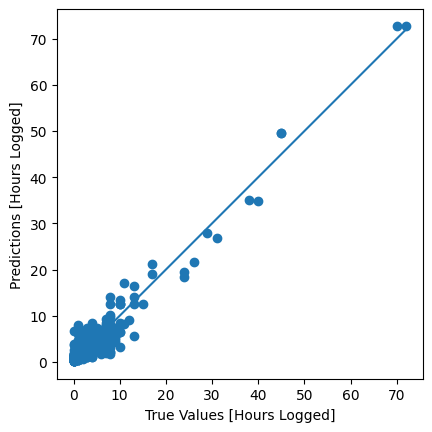

In [29]:
axes = plt.axes(aspect='equal')
plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [Hours Logged]')
plt.ylabel('Predictions [Hours Logged]')
# calculate the limit
max_value = max(test_label.max(), test_predictions[0].max())
_ = plt.plot([0, max_value], [0, max_value])
plt.savefig(r"./outputs/neural_network/prediction_plot_sip.png")

## Evaluating the model

The metrics we choose to evaluate the model were **Mean Abs. Error** and **Mean squarred Error**

### Showing the resulting metrics from the training

In [26]:

def evaluating_neural_network_model(histories):
    i = 0
    history_datasets = []
    for history in histories:
        history_dataset = pd.DataFrame(history.history)
        history_dataset['epoch'] = history.epoch
        history_dataset['fold'] = i
        i = i+1
        history_datasets.append(history_dataset)

        
    history_dataset = pd.concat(history_datasets)

    print("Resume of the training history model")
    display(HTML(history_dataset.head().to_html()))

    history_datasets_csv = history_dataset
    history_datasets_csv.to_csv(r"./outputs/neural_network/history_sip.csv", index=False)  

    fold_histories = {
        f'Fold {i}': history for i, history in enumerate(histories)
    }

    print("Plotting the training history model per epoch")

    plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
    plotter.plot(fold_histories, metric="mse")
    plt.ylabel('MSE [Metric]')
    plt.show()

In [27]:
def evaluating_svc_model(history, test_predictions):
    history['MAE'] = [mean_absolute_error(test_label, test_predictions)]
    history['MSE'] = [mean_squared_error(test_label, test_predictions)]

    display(HTML(history.to_html()))

    history.to_csv(r"./outputs/svr/history_sip.csv", index=False)   

    # saving the results
    pd.DataFrame({
        'Logged': test_label,
        'Predicted': test_predictions
    }).to_csv(r"./outputs/svr/history_sip.csv", index=False)

Resume of the training history model


,loss,accuracy,mae,mse,val_loss,val_accuracy,val_mae,val_mse,epoch
295,4.419940,0.300573,1.444720,4.419940,4.316308,0.318519,1.391977,4.316308,295
296,4.279715,0.313613,1.422082,4.279715,4.329107,0.311111,1.393596,4.329107,296
297,4.262016,0.303438,1.431027,4.262016,4.463668,0.320988,1.387453,4.463668,297
298,4.352972,0.310115,1.429977,4.352971,4.423932,0.316049,1.397459,4.423932,298
299,4.569749,0.308524,1.465431,4.569749,4.330206,0.288889,1.451572,4.330206,299


Plotting the training history model per epoch


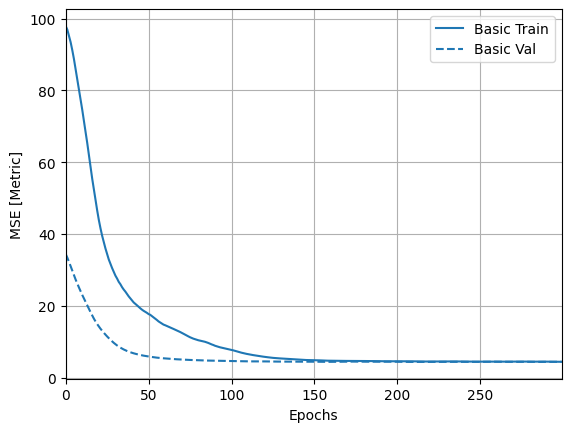

In [28]:
evaluating_neural_network_model(history)
# evaluating_svc_model(history, test_predictions)

In [30]:
model.save(r"./outputs/neural_network/model_sip.h5")

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
import netron
netron.start(r"./outputs/neural_network/model_sip.h5")

Serving './outputs/neural_network/model_sip.h5' at http://localhost:8080


('localhost', 8080)